In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats
import pymc3 as pm

%matplotlib inline

/Users/reef/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/reef/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
senate = pd.read_csv('./data/senate.csv')

In [5]:
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
        1. Tokenizes and removes punctuation
        2. Removes stopwords
        3. Stems
        4. Returns a list of the cleaned text
    '''
    if pd.isnull(text):
        return []
    # tokenizing and removing punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed=tokenizer.tokenize(text)
    
    # removing any stopwords
    text_processed = [word.lower() for word in text_processed if word.lower() not in stopwords.words('english')]
    
    # steming
    porter_stemmer = PorterStemmer()
    
    text_processed = [porter_stemmer.stem(word) for word in text_processed]
    
    try:
        text_processed.remove('b')
    except: 
        pass

    return text_processed 

In [7]:
senate.head()

,created_at,id_str,reply_count,retweet_count,text,user,name,state,party,the_ratio
0,Sun May 21 19:26:26 +0000 2017,8.660000e+17,116.0,174.0,"Franni here. Since it's Al's birthday, and sin...",alfranken,Al Franken,New York,Democratic,0.666667
1,Tue May 16 01:44:44 +0000 2017,8.640000e+17,718.0,1248.0,This is profoundly troubling. Why would Presid...,alfranken,Al Franken,New York,Democratic,0.575321
2,Wed May 10 19:55:37 +0000 2017,8.620000e+17,218.0,1334.0,It couldn't be clearer: we need an independent...,alfranken,Al Franken,New York,Democratic,0.163418
3,Wed May 10 19:54:55 +0000 2017,8.620000e+17,134.0,794.0,More troubling news: AG Sessions was involved ...,alfranken,Al Franken,New York,Democratic,0.168766
4,Wed May 10 19:54:20 +0000 2017,8.620000e+17,131.0,556.0,Troubling news that you probably know by now: ...,alfranken,Al Franken,New York,Democratic,0.235612


In [8]:
senate.the_ratio.describe()

count    219539.000000
mean          0.677336
std           1.847231
min           0.000000
25%           0.046512
50%           0.250000
75%           0.636364
max         138.000000
Name: the_ratio, dtype: float64

In [41]:
y = senate['the_ratio']
X = senate['text']

#cv = CountVectorizer(stop_words='english')
#cv.fit(X)

#X = pd.DataFrame(cv.transform(X).todense(), columns=cv.get_feature_names())

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state=42)

In [21]:
%%time
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english', strip_accents='ascii')), # lowercase=True by defaul
    ('rfr', RandomForestRegressor())
]) 
pipeline.fit(X_train, y_train)

CPU times: user 2h 30min 19s, sys: 28.1 s, total: 2h 30min 48s
Wall time: 2h 31min 2s


In [22]:
pipeline.score(X_train, y_train)

0.8414908077302007

In [23]:
pipeline.score(X_test, y_test)

-0.009979300922180023

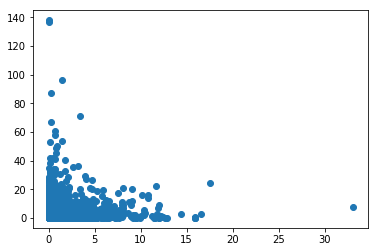

In [26]:
y_preds = pipeline.predict(X_test)
plt.scatter(y_preds, y_test)

In [16]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english', strip_accents='ascii')), # lowercase=True by default
    ('tfidf', TfidfTransformer()),
    ('rfr', RandomForestRegressor())
]) 
pipeline.fit(X_train, y_train)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...timators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [18]:
pipeline.score(X_test, y_test)

-0.09365265111963894

In [20]:
pipeline.score(X_train, y_train)

0.8391233212269594

In [17]:
y_preds = pipeline.predict(X_test)

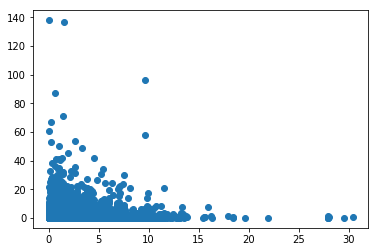

In [19]:
plt.scatter(y_preds, y_test)

### Predicting partisanship

In [42]:
bipartisan['party'].value_counts()

Republican    115566
Democratic     98558
Name: party, dtype: int64

In [43]:
baseline_accuracy = bipartisan['party'].value_counts()[0]/len(bipartisan['party'])
baseline_accuracy

0.5397153051502868

In [44]:
%%time

#with count vectorizer
y = bipartisan['party']
X = bipartisan['text']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state=42)

le = LabelEncoder()
le.fit(y)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english', strip_accents='ascii')), # lowercase=True by default
    ('rfc', RandomForestClassifier())
]) 
pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
print(pipeline.score(X_test, y_test))

0.9916803437278998
0.7665556212833525
CPU times: user 4min 15s, sys: 1.32 s, total: 4min 16s
Wall time: 4min 17s


In [45]:
print(pipeline.score(X_train, y_train))
print(pipeline.score(X_test, y_test))

0.9916803437278998
0.7665556212833525


In [18]:
y_preds = pipeline.predict(X_test)

df_confusion = pd.crosstab(y_test, y_preds)
df_confusion

col_0,0,1
row_0,,
0,22625,6755
1,7982,26876


#### Gridsearching pipeline

In [73]:
params_grid = {
    'vect__stop_words': [None, 'english'],
    'vect__strip_accents': ['ascii', 'unicode'],
    'vect__min_df': [1,5,10,20],
    'rfc__n_estimators': [5,10,15,20],
    'rfc__max_depth': [5,10,15,20,None],
    'rfc__criterion': ['gini', 'entropy']
}

In [ ]:
%%time
gs = GridSearchCV(pipeline, params_grid, n_jobs = 1)

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))
print(gs.best_params_)

In [23]:
%%time

#with tfidf
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()), # lowercase=True by default
    ('rfc', RandomForestClassifier())
     ])
pipeline.fit(X_train, y_train)

print(pipeline.score(X_train, y_train))
print(pipeline.score(X_test, y_test))

0.991293382971058
0.7145459074068309
CPU times: user 3min 32s, sys: 1.44 s, total: 3min 34s
Wall time: 3min 34s


In [24]:
y_preds = pipeline.predict(X_test)

df_confusion = pd.crosstab(y_test, y_preds)
df_confusion

col_0,0,1
row_0,,
0,20601,8779
1,9558,25300


#### Below is the effect of using our text_process function

In [27]:
X = bipartisan['text'].apply(text_process)

In [28]:
X

0         [franni, sinc, al, birthday, sinc, work, hard,...
1         [profoundli, troubl, would, presid, trump, giv...
2         [clearer, need, independ, investig, presid, tr...
3         [troubl, news, ag, session, involv, fire, jeff...
4         [troubl, news, probabl, know, presid, trump, f...
5         [still, word, describ, sad, know, lui, gone, p...
6         [tuesdayspromis, remark, move, amp, time, book...
7         [congrat, namiminnesota, 40, year, incred, wor...
8         [kick, saturday, meet, minnesotan, age, st, pa...
9         [great, catch, melissahortman, minnesota, hous...
10        [share, stori, amp, make, voic, heard, hold, g...
11        [need, fight, back, million, disabl, elderli, ...
12        [need, fight, back, older, american, could, ch...
13        [need, fight, back, work, famili, would, face,...
14        [need, fight, back, million, peopl, minnesota,...
15        [bill, pass, hous, yesterday, time, major, us,...
16        [gop, took, health, bill, appr

In [35]:
print(str(X[0]))

['franni', 'sinc', 'al', 'birthday', 'sinc', 'work', 'hard', 'want', 'us', 'someth', 'special', 'http', 'co', 'glglcprbj8']


In [36]:
%%time 
y = bipartisan['party']
X = str(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state=42)

le = LabelEncoder()
le.fit(y)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english', strip_accents='ascii')), # lowercase=True by default
    ('rfc', RandomForestClassifier())
]) 
pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
print(pipeline.score(X_test, y_test))

ValueError: Found input variables with inconsistent numbers of samples: [3701, 214124]

In [ ]:
y_preds = pipeline.predict(X_test)

df_confusion = pd.crosstab(y_test, y_preds)
df_confusion

In [ ]:
#with tfidf
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()), # lowercase=True by default
    ('rfc', RandomForestClassifier())
     ])
pipeline.fit(X_train, y_train)

print(pipeline.score(X_train, y_train))
print(pipeline.score(X_test, y_test))

In [ ]:
y_preds = pipeline.predict(X_test)

df_confusion = pd.crosstab(y_test, y_preds)
df_confusion

#### Let the gridsearch begin!